<a href="https://colab.research.google.com/github/arjunjyothieswarb/EECE5550/blob/main/HW5/EECE5550_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5: Simultaneous Localization & Mapping (SLAM)

## EECE 5550: Mobile Robotics (Spring 2024)

**Collaboration Statement:**

In [1]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-w50l1e4q
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-w50l1e4q
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 19.7 MB/s eta 0:00:00
  Created wheel for gym-neu-racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65580 sha256=db6bda69158e51b3a8a06749b9935b69f8c3768a8ae90e19d207be946136b4dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-enxbsrwh/wheels/2b/40/20/13d3d44e20167f192ae2e89c0c279882d6064e6d226cc3efaa
Successfully built gym-neu-racing


In [3]:
!pip install gtsam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 15.9 MB/s eta 0:00:00


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [4]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
from gym_neu_racing.sensor_models.sensor_model import SensorModel
from typing import Iterable, Optional
import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam import Marginals, Point2, Point3, Pose2, Pose3, Values
from gtsam.symbol_shorthand import L, X
from matplotlib import patches
from scipy.linalg import expm

These functions maya be helpful for plotting your pose estimates:

In [5]:
# bug in gtsam.utils.plot use of ellipse
# fixed by https://github.com/borglab/gtsam/pull/1681
# but not merged into main yet


def plot_point2_on_axes(
    axes, point: Point2, linespec: str, P: Optional[np.ndarray] = None
) -> None:
    """
    Plot a 2D point and its corresponding uncertainty ellipse on given axis
    `axes` with given `linespec`.

    The uncertainty ellipse (if covariance is given) is scaled in such a way
    that 95% of drawn samples are inliers, see `plot_covariance_ellipse_2d`.

    Args:
        axes (matplotlib.axes.Axes): Matplotlib axes.
        point: The point to be plotted.
        linespec: String representing formatting options for Matplotlib.
        P: Marginal covariance matrix to plot the uncertainty of the estimation.
    """
    axes.plot([point[0]], [point[1]], linespec, marker=".", markersize=10)
    if P is not None:
        plot_covariance_ellipse_2d(axes, point, P)


def plot_point2(
    fignum: int,
    point: Point2,
    linespec: str,
    P: np.ndarray = None,
    axis_labels: Iterable[str] = ("X axis", "Y axis"),
) -> plt.Figure:
    """
    Plot a 2D point on given figure with given `linespec`.

    The uncertainty ellipse (if covariance is given) is scaled in such a way
    that 95% of drawn samples are inliers, see `plot_covariance_ellipse_2d`.

    Args:
        fignum: Integer representing the figure number to use for plotting.
        point: The point to be plotted.
        linespec: String representing formatting options for Matplotlib.
        P: Marginal covariance matrix to plot the uncertainty of the estimation.
        axis_labels: List of axis labels to set.

    Returns:
        fig: The matplotlib figure.

    """
    fig = plt.figure(fignum)
    axes = fig.gca()
    plot_point2_on_axes(axes, point, linespec, P)

    axes.set_xlabel(axis_labels[0])
    axes.set_ylabel(axis_labels[1])

    return fig


def plot_pose2_on_axes(
    axes, pose: Pose2, axis_length: float = 0.1, covariance: np.ndarray = None
) -> None:
    """
    Plot a 2D pose on given axis `axes` with given `axis_length`.

    The ellipse is scaled in such a way that 95% of drawn samples are inliers,
    see `plot_covariance_ellipse_2d`.

    Args:
        axes (matplotlib.axes.Axes): Matplotlib axes.
        pose: The pose to be plotted.
        axis_length: The length of the camera axes.
        covariance (numpy.ndarray): Marginal covariance matrix to plot
            the uncertainty of the estimation.
    """
    # get rotation and translation (center)
    gRp = pose.rotation().matrix()  # rotation from pose to global
    t = pose.translation()
    origin = t

    # draw the camera axes
    x_axis = origin + gRp[:, 0] * axis_length
    line = np.append(origin[np.newaxis], x_axis[np.newaxis], axis=0)
    axes.plot(line[:, 0], line[:, 1], "r-")

    y_axis = origin + gRp[:, 1] * axis_length
    line = np.append(origin[np.newaxis], y_axis[np.newaxis], axis=0)
    axes.plot(line[:, 0], line[:, 1], "g-")

    if covariance is not None:
        pPp = covariance[0:2, 0:2]
        gPp = np.matmul(np.matmul(gRp, pPp), gRp.T)
        plot_covariance_ellipse_2d(axes, origin, gPp)


def plot_pose2(
    fignum: int,
    pose: Pose2,
    axis_length: float = 0.1,
    covariance: np.ndarray = None,
    axis_labels=("X axis", "Y axis", "Z axis"),
) -> plt.Figure:
    """
    Plot a 2D pose on given figure with given `axis_length`.

    The uncertainty ellipse (if covariance is given) is scaled in such a way
    that 95% of drawn samples are inliers, see `plot_covariance_ellipse_2d`.

    Args:
        fignum: Integer representing the figure number to use for plotting.
        pose: The pose to be plotted.
        axis_length: The length of the camera axes.
        covariance: Marginal covariance matrix to plot
            the uncertainty of the estimation.
        axis_labels (iterable[string]): List of axis labels to set.
    """
    # get figure object
    fig = plt.figure(fignum)
    axes = fig.gca()
    plot_pose2_on_axes(
        axes, pose, axis_length=axis_length, covariance=covariance
    )

    axes.set_xlabel(axis_labels[0])
    axes.set_ylabel(axis_labels[1])

    return fig


def plot_covariance_ellipse_2d(
    axes, origin: Point2, covariance: np.ndarray
) -> None:
    """
    Plots a Gaussian as an uncertainty ellipse

    The ellipse is scaled in such a way that 95% of drawn samples are inliers.
    Derivation of the scaling factor is explained at the beginning of this file.

    Args:
        axes (matplotlib.axes.Axes): Matplotlib axes.
        origin: The origin in the world frame.
        covariance: The marginal covariance matrix of the 2D point
                    which will be represented as an ellipse.
    """

    w, v = np.linalg.eigh(covariance)

    # this corresponds to 95%, see note above
    k = 2.447746830681

    angle = np.arctan2(v[1, 0], v[0, 0])
    # We multiply k by 2 since k corresponds to the radius but Ellipse uses
    # the diameter.
    e1 = patches.Ellipse(
        origin,
        np.sqrt(w[0]) * 2 * k,
        np.sqrt(w[1]) * 2 * k,
        angle=np.rad2deg(angle),
        fill=False,
    )
    axes.add_patch(e1)

You can create an instance of the simulator that you'll build on throughout the assignment:

# Problem 1: Factor Graphs

## 1a) Factor Graphs with Odometry from Motion Model

In the previous assignment, you were given either the robot's true state *or* the true map. In this problem, you'll implement a basic version of SLAM, where you only have access to the robot's control inputs and measurements (not the true state or map).

To begin, in this part you will create an `OdometryFactorGraph` that estimates the robot's pose over time, using control inputs and the `Unicycle` motion model. Meanwhile, the simulator itself (the "true robot") will be using the `NoisyUnicycle` motion model. By defining a factor graph and solving the corresponding inference problem, you will obtain an estimate of the pose (i.e., its mean and covariance at each timestep). Your `step` method will return this estimate, and we provide some functions for plotting this estimate against the true system state.

To set up your factor graph, you'll need to implement a few methods:
- `add_prior_pose_factor`: add a `PriorFactorPose2` at the origin to encode where the robot starts
- `add_motion_model_factor`: add a `BetweenFactorPose2` with the relative transformation between the current pose and previous pose
- `solve`: find the optimal estimates for each variable node (\Theta_j in lecture) using the cost function that your factor graph defines

We implemented `step` for you, but you are welcome to modify that as well.

**Deliverables**:
- Implement the three methods listed above
- Generate a plot of your robot's true pose (unknown to the odometry algorithm) vs. the mean/covariance describing your odometry algorithm's belief of the robot's pose. These won't line up perfectly, because you are using a different motion model than the true system.

In [6]:
class OdometryFactorGraph:
    def __init__(self, dt=0.1, motion_model=motion_models.Unicycle()):

        self.dt = dt
        self.motion_model = motion_model

        self.prior_noise = gtsam.noiseModel.Diagonal.Sigmas(
            np.array([0.01, 0.01, 0.01])
        )
        self.odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(
            1e-2 * np.ones(3)
        )

        self.graph = gtsam.NonlinearFactorGraph()
        self.initial_estimate = gtsam.Values()

        self.current_state_index = 0
        self.current_state = np.array([0.0, 0.0, 0.0])
        self.poses = []

    def add_motion_model_factor(self, control: np.ndarray) -> None:
        # Compute pose at current timestep expressed in frame at previous timestep
        # using self.motion_model.step
        # Create a BetweenFactorPose2 between self.poses[-2] and self.poses[-1]
        # Add that factor to self.graph
        next_state = self.motion_model.step(self.current_state, control, self.dt)
        Estimated_Pose = gtsam.Pose2(next_state[0], next_state[1], next_state[2])
        BetweenFactorPose2 =  gtsam.BetweenFactorPose2(self.poses[-2], self.poses[-1], Estimated_Pose, self.odometry_noise)
        self.graph.add(BetweenFactorPose2)

        # raise NotImplementedError

    def add_prior_pose_factor(self) -> None:
        # Create a PriorFactorPose2 for self.poses[-1]
        # Add that factor to self.graph
        Initial_Pose = gtsam.Pose2(0.0, 0.0, 0.0)
        PriorFactorPose2 = gtsam.PriorFactorPose2(self.poses[-1], Initial_Pose, self.prior_noise)
        self.graph.add(PriorFactorPose2)

        # raise NotImplementedError

    def solve(self):
        # Optimize current self.graph using self.initial_estimate and params
        # Return the result (from optimizer.optimize()) and corresponding
        # marginals (from gtsam.Marginals(self.graph, result))

        parameters = gtsam.GaussNewtonParams()

        # Stop iterating once the change in error between steps is less than this value
        parameters.setRelativeErrorTol(1e-5)

        # Do not perform more than N iteration steps
        parameters.setMaxIterations(100)

        # Create the optimizer ...
        optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial_estimate, parameters)

        result = optimizer.optimize()
        marginals = gtsam.Marginals(self.graph, result)
        # raise NotImplementedError

        return result, marginals

    def step(self, obs: dict, action: np.ndarray) -> dict:
        # Each time step is called, add nodes & factors to self.graph and solve
        # for the MLE estimate.

        # To make it clear what each variable means, you can use
        # X(1), X(2), ... for states and L(1), L(2), ... for landmarks in GTSAM.

        # Add new pose variable to factor graph, along with an initial estimate
        self.poses.append(X(self.current_state_index))
        self.initial_estimate.insert(
            self.poses[-1], gtsam.Pose2(0.0, 0.0, 0.0)
        )

        # Add factors between poses (otherwise you'd just have a graph of variable nodes)
        if self.current_state_index == 0:
            # on the first step, just add a prior pose (no relative motion yet)
            self.add_prior_pose_factor()
        else:
            # add factor for relative motion between current and last pose
            self.add_motion_model_factor(action)

        # Solve for the MLE estimate of each variable in self.graph
        result, marginals = self.solve()

        # Store the Pose2 and Covariance results in estimates
        pose_means = []
        pose_covariances = []
        for var in self.poses:
            pose_means.append(result.atPose2(var))
            pose_covariances.append(marginals.marginalCovariance(var))
        estimates = {
            'pose_means': pose_means,
            'pose_covariances': pose_covariances,
        }

        self.current_state_index += 1
        return estimates

You can check your `OdometryFactorGraph` class with the following snippet:

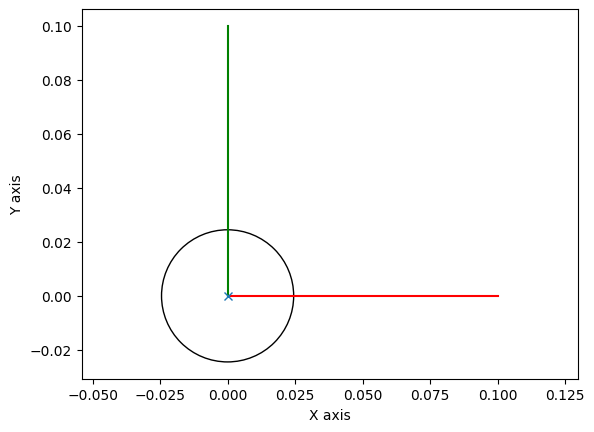

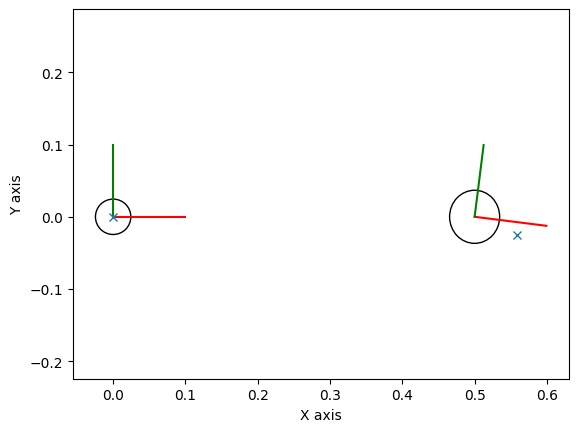

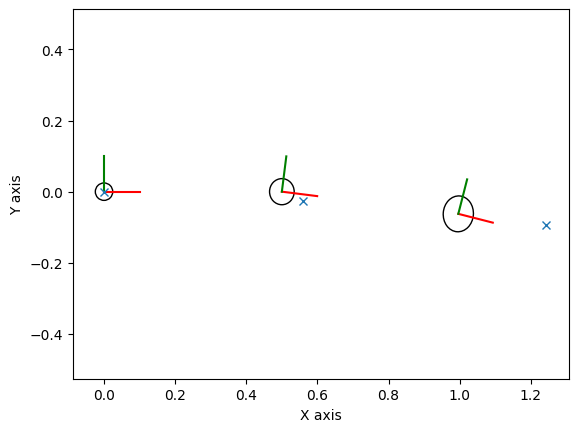

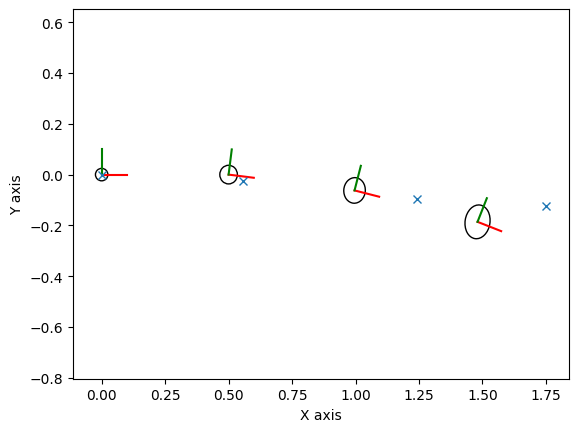

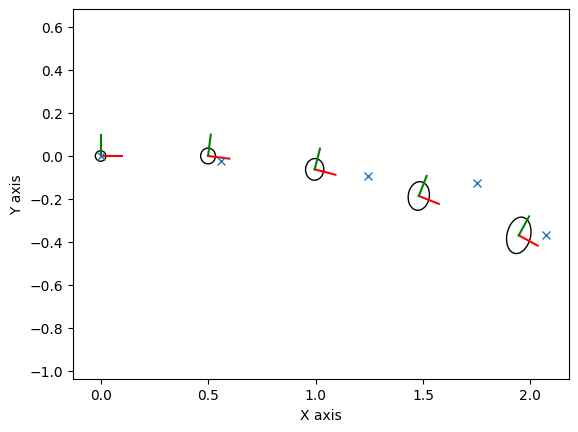

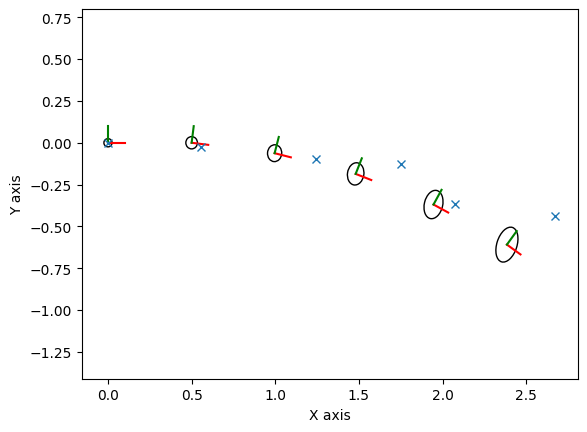

In [7]:
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# For this first part, you won't use any sensors (just the actions + motion model)
env.unwrapped.sensor_models = {}

# The true system (env) will use a NoisyUnicycle motion model.
# Feel free to change the magnitude of the process_noise_limits or try different
# motion models altogether.
env.unwrapped.motion_model = motion_models.NoisyUnicycle(
    process_noise_limits=np.array([0.2, 0.2, 0.1])
)

# Reset the environment and get the first observation
obs, _ = env.reset()

# We'll send a constant [vx, vw] at each timestep and start the system at the origin
action = np.array([1.0, -0.25])
env.unwrapped.state = np.array([0.0, 0.0, 0.0])
env.unwrapped.dt = 0.5
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

# Instantiate your OdometryFactorGraph
odometry = OdometryFactorGraph(dt=env.unwrapped.dt)

# Keep track of the true system state (only for visualization)
states = []
states.append(env.unwrapped.state)

num_timsteps = 6
for _ in range(num_timsteps):

    # At each timestep, add another timestep's pose to the factor graph
    estimates = odometry.step(obs, action)

    # Plot estimated poses with covariances
    for t in range(len(estimates["pose_means"])):
        plot_pose2(
            fignum=0,
            pose=estimates["pose_means"][t],
            axis_length=0.1,
            covariance=estimates["pose_covariances"][t],
        )

    # Plot true states
    plt.plot([state[0] for state in states], [state[1] for state in states], "x")

    plt.axis('equal')
    plt.show()

    # Finally, run the simulator forward one timestep
    obs, _, _, _, _ = env.step(action)
    states.append(env.unwrapped.state)

## 1b) Additionally estimate position of static landmarks in environment

The previous part was just a warmup to get you familiar with GTSAM and working with factor graphs in code. But, it still wasn't SLAM, since you were only estimating the robot's pose.

In this part, you will also estimate the position of a few static landmarks in the environment. To make this easier, we provide a `LandmarkSensor` below, which provides a range and bearing estimate to each landmark in the environment at each timestep. On a real robot, this type of sensor reading could be obtained with a receiver/antenna on the robot that listens to some fixed beacons in the environment broadcasting a signal (e.g., wifi, sonar). This setup is particularly useful underwater, where GPS is not available.

In particular, you should implement the following methods:
- `add_landmark_nodes`: at the start of the mission, add some Point2 variables to the factor graph to encode the landmark positions
- `add_landmark_factors`: at each timestep, add a `BearingRangeFactor2D` between each landmark and the current pose

**Deliverables**:
- Implement the `LandmarkSLAM` class by completing the methods listed above
- Generate the same plot as in the previous part, but also add the mean and covariance of your landmark pose estimates along with the true (unknown to the SLAM algorithm) landmark positions (your estimates should probably get closer to the true positions as you collect more data).
- Experiment with different settings for `self.measurement_noise`, `self.odometry_noise`, and the variances in the sensor and motion models, and write a few sentences about your findings.

In [8]:
class LandmarkSensor(gym_neu_racing.sensor_models.sensor_model.SensorModel):
    """Sensor model that returns noisy (range, bearing) of landmarks."""

    def __init__(
        self, landmarks, range_variance=0.1**2, bearing_variance=0.1**2
    ):
        super().__init__()
        self.landmarks = landmarks
        self.range_variance = range_variance
        self.bearing_variance = bearing_variance

        self.observation_space = spaces.Dict(
            {
                "bearings": spaces.Box(
                    -np.inf, np.inf, shape=(landmarks.shape[0],), dtype=float
                ),
                "ranges": spaces.Box(
                    -np.inf, np.inf, shape=(landmarks.shape[0],), dtype=float
                ),
            }
        )

    def step(self, current_state: np.ndarray) -> dict:

        # Calculate the ideal range/bearing measurements
        relative_positions = self.landmarks - current_state[:2]
        ranges = np.linalg.norm(relative_positions, axis=1)
        bearings = (
            np.arctan2(relative_positions[:, 1], relative_positions[:, 0])
            - current_state[2]
        )

        # Add some Gaussian noise to the ideal range/bearing measurements
        ranges_reading = np.random.normal(ranges, self.range_variance)
        bearings_reading = np.random.normal(bearings, self.bearing_variance)

        return {"ranges": ranges_reading, "bearings": bearings_reading}

In [11]:
class LandmarkSLAM(OdometryFactorGraph):
    def __init__(self, dt=0.1, motion_model=motion_models.Unicycle()):

        # LandmarkSLAM will be a child class of OdometryFactorGraph from above,
        # and will just add some methods for adding landmark nodes/factors
        # to supplement the nodes/factors from the motion model
        super().__init__(dt=dt, motion_model=motion_model)

        self.measurement_noise = gtsam.noiseModel.Diagonal.Sigmas(
            np.array([0.5, 0.5])
        )

        self.landmarks = [] # None
        self.landmark_index = 0

    def add_landmark_nodes(self, landmark_measurements: dict) -> None:

        # Just like we populated self.poses with a bunch of X(i) variables,
        # you should populate self.landmarks with a list of L(i) variables,
        # You can assume there are a constant number of landmarks throughtout
        # the mission, and you receive a measurement about each landmark at
        # every timestep, you receive a measurement.
        # Also, make sure to add to self.initial_estimates for each landmark.

        # self.landmarks.append(L(self.current_state_index))
        # print(landmark_measurements)
        # landmarks = []
        ranges = landmark_measurements['ranges']
        bearings = landmark_measurements['bearings']

        # print(landmark_measurements)

        for i in range(len(ranges)):
            self.landmarks.append(L(self.landmark_index))
            # self.initial_estimate.insert(self.landmarks[-1], (0.0, 0.0))
            self.initial_estimate.insert(self.landmarks[-1], (ranges[i], bearings[i]))
            self.landmark_index = self.landmark_index + 1

        # raise NotImplementedError

    def add_landmark_factors(self, landmark_measurements: dict) -> None:
        # For each landmark, add a BearingRangeFactor2D to the graph between
        # the current pose and that landmark.

        ranges = landmark_measurements['ranges']
        bearings = landmark_measurements['bearings']

        n = len(ranges)
        for i in range(n):
            BearingRange2D = gtsam.BearingRange2D(gtsam.Rot2(bearings[i]), ranges[i])
            BearingRangeFactor2D = gtsam.BearingRangeFactor2D(self.poses[-1], self.landmarks[i-n], gtsam.Rot2(bearings[i]), ranges[i], self.measurement_noise)
            self.graph.add(BearingRangeFactor2D)


        # raise NotImplementedError

    def step(self, obs: dict, action: np.ndarray) -> dict:

        # add new pose variable to factor graph
        self.poses.append(X(self.current_state_index))
        self.initial_estimate.insert(
            self.poses[-1], gtsam.Pose2(0.0, 0.0, 0.0)
        )

        if self.current_state_index == 0:
            self.add_prior_pose_factor()

            # on the first timestep, add the landmarks as nodes in the graph
            self.add_landmark_nodes(obs["landmarks"])
        else:
            self.add_motion_model_factor(action)

        # each timestep, add the range/bearing factor btwn each landmark and the
        # current robot pose
        self.add_landmark_factors(obs["landmarks"])

        # Solve for the MLE estimate of each variable in self.graph
        result, marginals = self.solve()

        # After solving the factor graph inference problem, store the results
        # in a convenient format for plotting later
        pose_means = []
        pose_covariances = []
        for var in self.poses:
            pose_means.append(result.atPose2(var))
            pose_covariances.append(marginals.marginalCovariance(var))

        landmark_means = []
        landmark_covariances = []
        for var in self.landmarks:
            landmark_means.append(result.atPoint2(var))
            landmark_covariances.append(marginals.marginalCovariance(var))

        estimates = {
            'pose_means': pose_means,
            'pose_covariances': pose_covariances,
            'landmark_means': landmark_means,
            'landmark_covariances': landmark_covariances,
        }

        self.current_state_index += 1
        return estimates

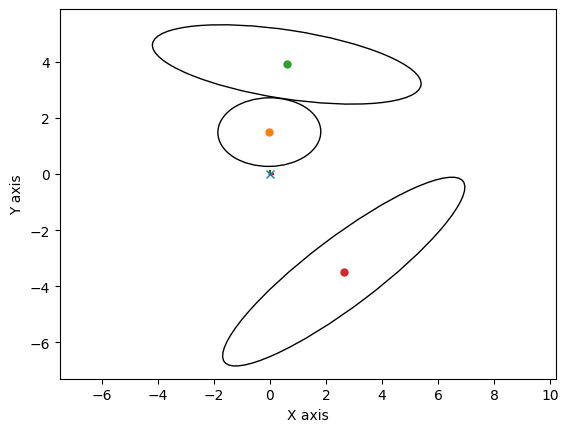

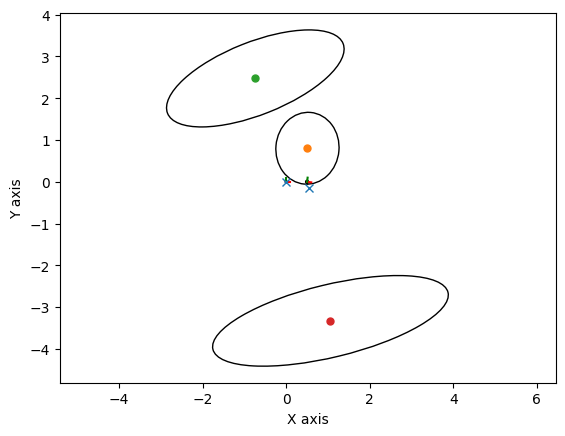

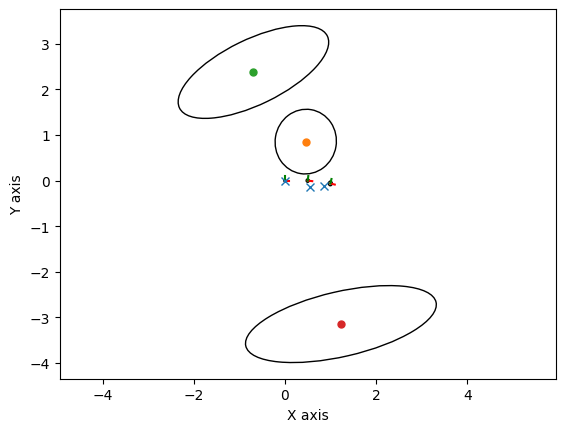

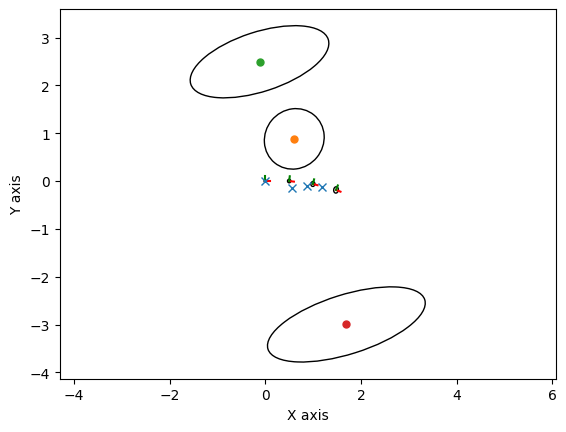

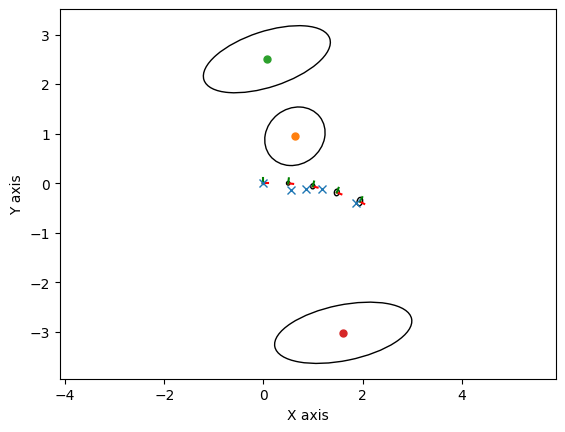

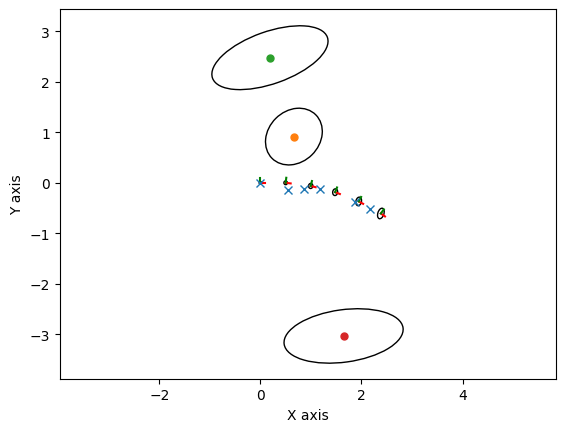

In [12]:
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# 3 landmarks with (x,y) coordinates in the world frame
env.unwrapped.landmarks = np.array(
    [
        [0.5, 0.9],
        [-0.2, 2.4],
        [1.7, -3.1],
    ]
)

# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# Tell the environment to use the LandmarkSensor (which computes range/bearings)
env.unwrapped.sensor_models = {
    "landmarks": LandmarkSensor(
        env.unwrapped.landmarks, range_variance=0.5**2, bearing_variance=0.5**2
    ),
}

# The true system (env) will use a NoisyUnicycle motion model.
# Feel free to change the magnitude of the process_noise_limits or try different
# motion models altogether.
env.unwrapped.motion_model = motion_models.NoisyUnicycle(
    process_noise_limits=np.array([0.2, 0.2, 0.1])
)

# Reset the environment and get the first observation
obs, _ = env.reset()

# We'll send a constant [vx, vw] at each timestep and start the system at the origin
action = np.array([1.0, -0.25])
env.unwrapped.state = np.array([0.0, 0.0, 0.0])
env.unwrapped.dt = 0.5
obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

# Instantiate your LandmarkSLAM class
slam = LandmarkSLAM(dt=env.unwrapped.dt)

# Keep track of the true system state (only for visualization)
states = []
states.append(env.unwrapped.state)

num_timsteps = 6
for _ in range(num_timsteps):

    # At each timestep, add another timestep's pose to the factor graph
    estimates = slam.step(obs, action)

    # Plot estimated *robot* poses with covariances
    for t in range(len(estimates["pose_means"])):
        plot_pose2(
            fignum=0,
            pose=estimates["pose_means"][t],
            axis_length=0.1,
            covariance=estimates["pose_covariances"][t],
        )

    # Plot true states
    plt.plot([state[0] for state in states], [state[1] for state in states], "x")

    # Plot estimated *landmark* positions with covariances
    for t in range(len(estimates["landmark_means"])):
        plot_point2(
            0,
            estimates["landmark_means"][t],
            "",
            estimates["landmark_covariances"][t],
        )

    plt.axis('equal')
    plt.show()

    # Finally, run the simulator forward one timestep
    obs, _, _, _, _ = env.step(action)
    states.append(env.unwrapped.state)

**Note:** For your final project, you could probably obtain a similar type of measurement about a landmark using the [april_tag_detector](https://wiki.ros.org/apriltag_ros) available in ROS.

## 1c) [Extra Credit]: Incorporate lidar measurements into your factor graph

So far, this assignment used the motion model and range/bearing measurements to a few fixed landmarks to construct a factor graph.

Building on the various things you learned this semester, you can earn extra credit by incorporating the lidar measurements into your factor graph. Here are some possible examples, but you're welcome to try other things:
- add additional factors between successive poses based on the pointclouds received (or replace the motion model altogether)
- add a loop closure factor after your robot has come back to the same place
- identify features/keypoints in the pointclouds that you want to treat as landmarks to estimate the position of (as opposed to relying on a few fixed landmarks)

These tasks may require a pointcloud registration component (e.g., you could implement ICP in <100 lines of code). You will also want to change the environment to `env = gymnasium.make("gym_neu_racing/NEURacing-v0")`, so that a world with a static map is used (you could use the examples from HW2-4 for this), and you'll want to modify `env.sensor_models` to include the lidar sensor (see HW4 for an example of that).